# Seminar #1. Anomaly detection
![](https://i1.wp.com/thedatascientist.com/wp-content/uploads/2019/02/anomaly_detection.png?fit=1024%2C683&ssl=1)

## Two mindsets for anomaly detection:

- When all you need is clean data, so you want to get rid of the anomalous data points. Often in cases where you have manual data input.

Example:


```
the technician was manually logging room temperature

room_temperature = [24.5, 23.2, 23.5, 22.9, 230, 23.2]
```
- When anomalies are points of interest and you want to detect anomalies for further action

Examples:
* Equipment failure
* Malicious activity in the network
* Fraud detection



## Case study: Readings from the field sensor during well-testing
![](https://thumbs.gfycat.com/MajorForcefulFossa-size_restricted.gif)

![](https://voxanalyzer.com/w3/images/productos/Medicion/IMG_20140917_090559477.jpg)

source: https://voxanalyzer.com/w3/images/productos/Medicion/IMG_20140917_090559477.jpg

In [2]:
%pylab inline 
%load_ext autoreload
%autoreload 2

# external
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Case 1: Surface sampling and well-testing

![](https://www.slb.com/-/media/images/ts/surface-testing/wellhead-sampling-manifold-combo.ashx?h=740&w=1110&la=en&hash=764405D1B7A6A8E6755D1951E641E50D)
source: https://www.slb.com/-/media/images/ts/surface-testing/wellhead-sampling-manifold-combo.ashx?h=740&w=1110&la=en&hash=764405D1B7A6A8E6755D1951E641E50D

In [3]:
data = pd.read_csv("../data/ASD_signal.csv")
data.index = pd.to_datetime(data['Date & Time'])

In [4]:
data.iloc[0].T

Date & Time          3/27/2018 0:05
qo_lc[m3/d]                  335.07
qw_lc[m3/d]                  5.7946
qg_lc[m3/d]                   14387
qo_sc[Sm3/d]                 246.36
                          ...      
OilPointHE[1/m]              12.054
WaterPointLE[1/m]            34.564
WaterPointHE[1/m]            16.819
GasPointLE[1/m]              1.1113
GasPointHE[1/m]             0.77893
Name: 2018-03-27 00:05:00, Length: 63, dtype: object

Text(0, 0.5, 'Pressure [bara]')

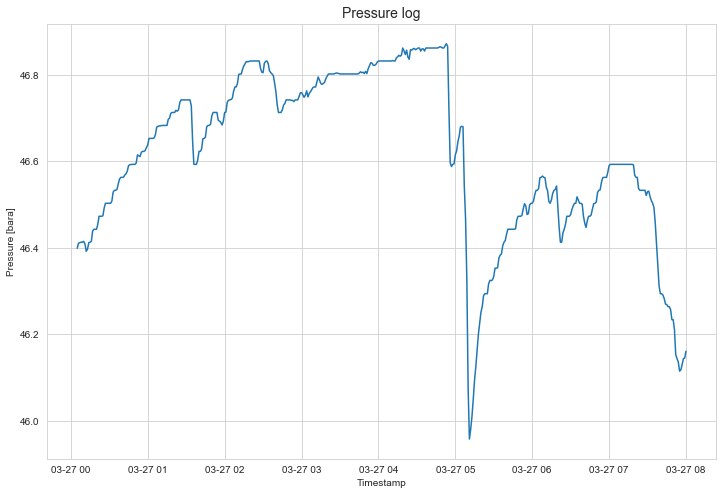

In [5]:
pylab.figure(figsize=(12,8))
pylab.title("Pressure log", size=14)
pylab.plot(data['POUT[bara]'])
pylab.xlabel('Timestamp')
pylab.ylabel('Pressure [bara]')

Text(0, 0.5, '% change')

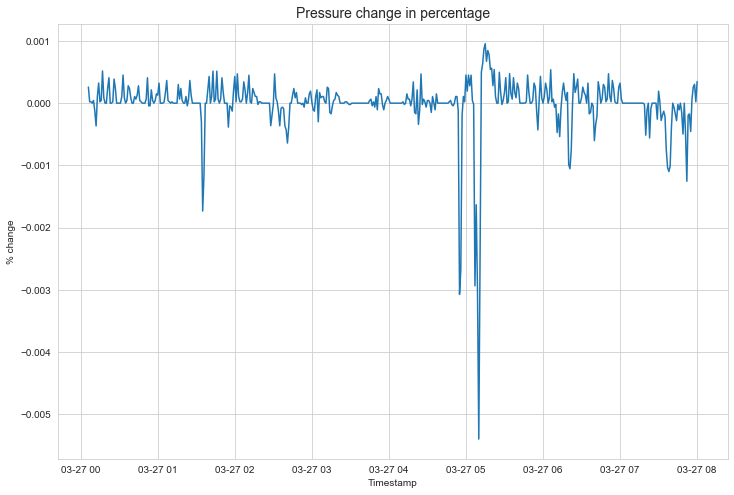

In [6]:
pylab.figure(figsize=(12,8))
pylab.title("Pressure change in percentage", size=14)
pylab.plot(data['POUT[bara]'].pct_change())
pylab.xlabel('Timestamp')
pylab.ylabel('% change')

# Z-score:

$\begin{equation*}\large
z-score = \frac{x - \mu}{\sigma} 
\end{equation*}$


In [7]:
data['POUT_pct_change'] = data['POUT[bara]'].pct_change().fillna(0)

mu = data['POUT_pct_change'].mean()
sigma = data['POUT_pct_change'].std()

data['POUT_z_score'] = data['POUT_pct_change'].apply(lambda x: (x-mu)/sigma)

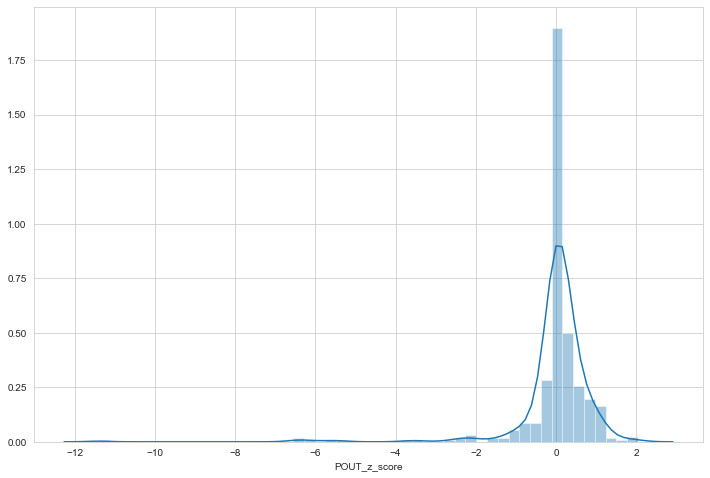

In [8]:
pylab.figure(figsize=(12,8))
sns.distplot(data['POUT_z_score'])

Text(0, 0.5, 'pct change')

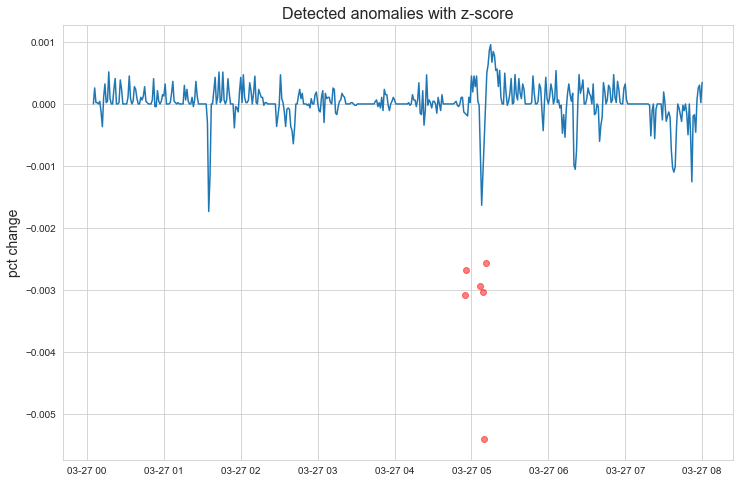

In [9]:
threshold = -4 # z-score threshold

pylab.figure(figsize=(12,8))
pylab.title("Detected anomalies with z-score", size=16)
pylab.plot(data[data['POUT_z_score']>threshold]['POUT_pct_change'])
pylab.scatter(data[data['POUT_z_score']<threshold]['POUT_pct_change'].index,
              data[data['POUT_z_score']<threshold]['POUT_pct_change'],
              color='r', 
              alpha=0.5)
pylab.ylabel('pct change', size=14)

Text(0, 0.5, 'Pressure [bara]')

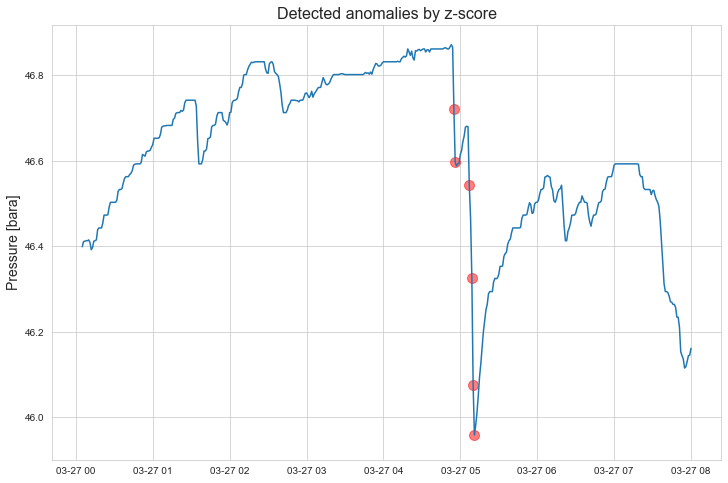

In [10]:
threshold = -4 # z-score threshold

pylab.figure(figsize=(12,8))
pylab.title("Detected anomalies by z-score", size=16)
pylab.plot(data[data['POUT[bara]']>threshold]['POUT[bara]'])
pylab.scatter(data[data['POUT_z_score']<threshold].index,
              data[data['POUT_z_score']<threshold]['POUT[bara]'],
              color='r', 
              alpha=0.5,
              s=100
             )
pylab.ylabel("Pressure [bara]", size=14)

In [11]:
data['anomaly_by_z_score'] = data['POUT_z_score'].apply(lambda x: 1 if x<threshold else 0)

## Anomalous timestamps

In [12]:
data[data['anomaly_by_z_score']==1]['Date & Time'].index

DatetimeIndex(['2018-03-27 04:55:00', '2018-03-27 04:56:00',
               '2018-03-27 05:07:00', '2018-03-27 05:09:00',
               '2018-03-27 05:10:00', '2018-03-27 05:11:00'],
              dtype='datetime64[ns]', name='Date & Time', freq=None)

---

# Case 2: Well flow rate monitoring

![](https://www.slb.ru/upload/img/Vx_Spectra_min.jpg)

source: https://www.slb.ru/upload/img/Vx_Spectra_min.jpg

In [67]:
flowrate = pd.read_csv("../data/qo_rate.csv")
flowrate.set_index('Date & Time', inplace=True)
flowrate.index = pd.to_datetime(flowrate.index)

In [68]:
flowrate.head()

,qo_lc[m3/d],qg_lc[m3/d]
Date & Time,,
2018-04-24 00:00:00,335.07,31933.796432
2018-04-24 00:01:00,340.51,38305.953303
2018-04-24 00:02:00,349.76,35991.115830
2018-04-24 00:03:00,314.72,29139.447285
2018-04-24 00:04:00,347.09,35841.065210


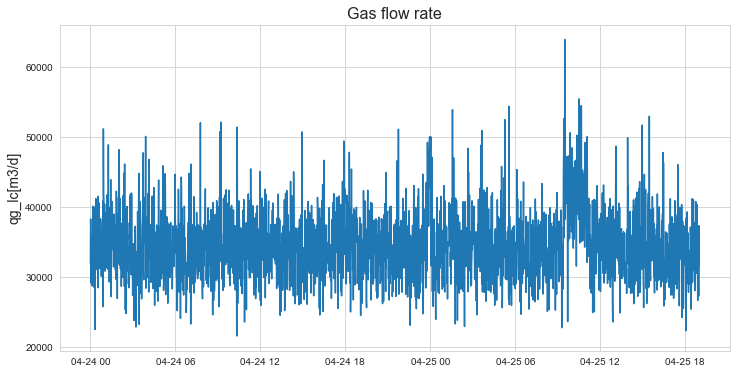

In [69]:
pylab.figure(figsize=(12,6))
pylab.title("Gas flow rate", size=16)
pylab.ylabel('qg_lc[m3/d]', size=14)
pylab.plot(flowrate['qg_lc[m3/d]'])

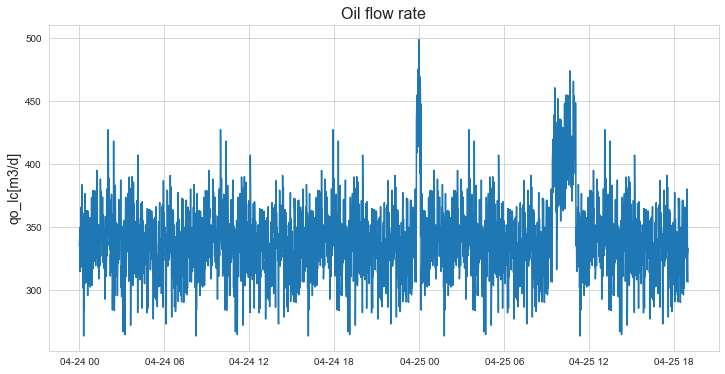

In [70]:
pylab.figure(figsize=(12,6))
pylab.title("Oil flow rate", size=16)
pylab.ylabel('qo_lc[m3/d]', size=14)
pylab.plot(flowrate['qo_lc[m3/d]'])

Text(0, 0.5, 'q gas, m3/d')

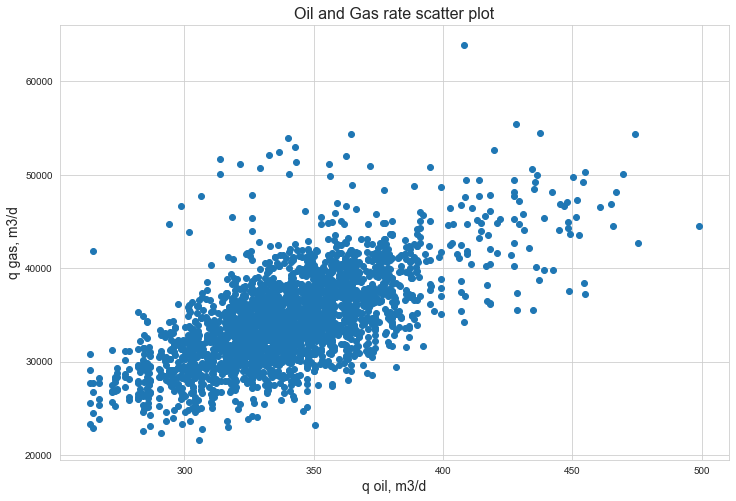

In [89]:
pylab.figure(figsize(12, 8))
pylab.title('Oil and Gas rate scatter plot', size=16)
pylab.scatter(flowrate['qo_lc[m3/d]'], flowrate['qg_lc[m3/d]'])
pylab.xlabel('qo_lc[m3/d', size=14)
pylab.ylabel('qg_lc[m3/d]', size=14)

## Local outlier factor

It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.

source: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_lof_outlier_detection_001.png)

source: https://scikit-learn.org/stable/auto_examples/neighbors/plot_lof_outlier_detection.html#sphx-glr-auto-examples-neighbors-plot-lof-outlier-detection-py

In [115]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=11, contamination=0.02)
outliers = lof.fit_predict(flowrate[['qo_lc[m3/d]', 'qg_lc[m3/d]']])

In [116]:
flowrate['anomaly_by_lof'] = outliers

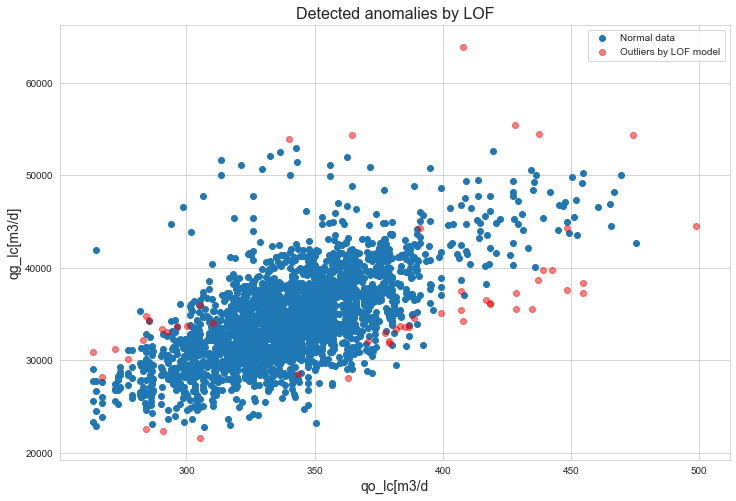

In [117]:
pylab.figure(figsize=(12,8))
pylab.title("Detected anomalies by LOF", size=16)
pylab.scatter(flowrate[flowrate['anomaly_by_lof']==1]['qo_lc[m3/d]'],
              flowrate[flowrate['anomaly_by_lof']==1]['qg_lc[m3/d]'],
              label='Normal data')
pylab.scatter(flowrate[flowrate['anomaly_by_lof']==-1]['qo_lc[m3/d]'],
              flowrate[flowrate['anomaly_by_lof']==-1]['qg_lc[m3/d]'],
              color='r', alpha=0.5, label='Outliers by LOF model')
pylab.xlabel('qo_lc[m3/d', size=14)
pylab.ylabel('qg_lc[m3/d]', size=14)
pylab.legend()

---

## Isolation Forest

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

source: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_isolation_forest_001.png)

source:
https://scikit-learn.org/stable/auto_examples/ensemble/plot_isolation_forest.html#sphx-glr-auto-examples-ensemble-plot-isolation-forest-py

In [118]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(contamination=0.01)
outliers = iforest.fit_predict(flowrate[['qo_lc[m3/d]', 'qg_lc[m3/d]']])

In [119]:
flowrate['anomaly_by_iforest'] = outliers

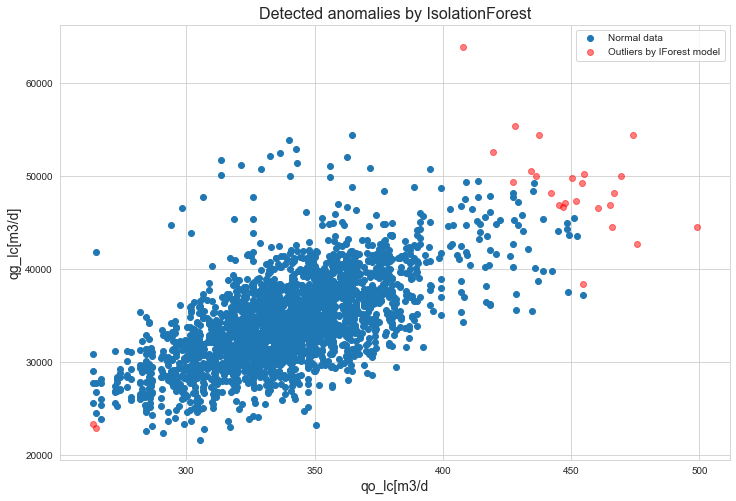

In [120]:
pylab.figure(figsize=(12,8))
pylab.title("Detected anomalies by IsolationForest", size=16)
pylab.scatter(flowrate[flowrate['anomaly_by_iforest']==1]['qo_lc[m3/d]'],
              flowrate[flowrate['anomaly_by_iforest']==1]['qg_lc[m3/d]'],
              label='Normal data')
pylab.scatter(flowrate[flowrate['anomaly_by_iforest']==-1]['qo_lc[m3/d]'],
              flowrate[flowrate['anomaly_by_iforest']==-1]['qg_lc[m3/d]'],
              color='r', alpha=0.5, label='Outliers by IForest model')
pylab.xlabel('qo_lc[m3/d', size=14)
pylab.ylabel('qg_lc[m3/d]', size=14)
pylab.legend()

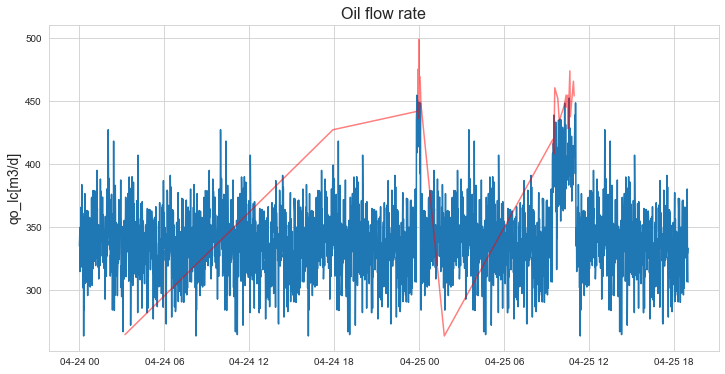

In [142]:
pylab.figure(figsize=(12,6))
pylab.title("Oil flow rate", size=16)
pylab.ylabel('qo_lc[m3/d]', size=14)
pylab.plot(flowrate[flowrate['anomaly_by_iforest']==1]['qo_lc[m3/d]'])
pylab.plot(flowrate[flowrate['anomaly_by_iforest']==-1]['qo_lc[m3/d]'], color='r', alpha=0.5)

Anomalies groped by time 

In [139]:
df = flowrate[flowrate['anomaly_by_iforest']==-1].groupby(pd.Grouper(freq='30min')).sum()
df[df['qg_lc[m3/d]']!=0]

,qo_lc[m3/d],qg_lc[m3/d],anomaly_by_lof,anomaly_by_iforest
Date & Time,,,,
2018-04-24 03:00:00,264.690,22879.637959,1,-1
2018-04-24 17:30:00,427.260,49428.695222,1,-1
2018-04-24 23:30:00,2319.395,233683.826569,3,-5
2018-04-25 00:00:00,1382.251,144055.577671,3,-3
2018-04-25 01:30:00,263.610,23322.537132,1,-1
2018-04-25 09:00:00,419.712,52626.802720,1,-1
2018-04-25 09:30:00,1754.940,208425.794119,2,-4
2018-04-25 10:00:00,2251.776,231971.831312,3,-5
2018-04-25 10:30:00,2259.612,258084.885295,-1,-5


----

# Let's practice!

In [193]:
# load data from well flowrate monitoring
regimes = pd.read_csv('../data/Oil_and_Gas_regimes.csv')

In [194]:
regimes.head()

,qo,qg
0,389.353764,2936.804706
1,351.169813,2873.516665
2,366.467218,3052.652835
3,347.727419,2851.290373
4,401.437531,2503.509918


## Visualize flow rate dependencies on the scatter plot

In [ ]:
# pylab.figure(figsize=(12,8))
# pylab.scatter()

## Try z-score

In [ ]:
# regimes['z_score'] = 

## Try LOF

In [ ]:
# lof = LoLocalOutlierFactor()

## Try Isolation Forest

In [ ]:
# iforest = IsolationForest()